## Introducción

Entrenamiento de modelo preentrenado para resolver el problema de predecir el ángulo del auto en base a la imagen.

Fuertemente basado en:
- https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

## Imports

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1, ConfusionMatrix
import pandas as pd
import sklearn
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import os

import importlib
import training_helper
import dataset_modules.one_part_dataset as opd
import metrics_helper

importlib.reload(training_helper)
importlib.reload(metrics_helper)
#importlib.reload(dataset_modules)

<module 'metrics_helper' from '/clusteruy/home/franco.cuevas/metrics_helper.py'>

## Variables

In [2]:
MODEL_NAME = "one_part_model"
EXPERIMENT_NAME = "resnet50_paragolpe_fine_tuning-norepairs"
FEATURE_EXTRACTION = False

device_string = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)

if device_string == "cuda":
    print("Usando GPU!")

os.makedirs("./trained_models/{}/{}/".format(MODEL_NAME, EXPERIMENT_NAME), exist_ok=True)

Usando GPU!


## Dataset

Se crea un dataset de tipo `ImageFolder` que se toma de la carpeta `dataset`, donde cada subcarpeta es una de las categorías a entrenar. 

Automáticamente mapea categorías a números `dataset.class_to_idx`.

Finalmente se hace el split en train y test en 80/20.

In [3]:
print("start to load dataset")
dataset = opd.OnePartDataset(
    "Paragolpe Delantero",
    transform=transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    preload=True,
    ignore_repair=True
)
print("finish to load dataset")

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

classes = dataset.classes

dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

print("#TRAIN {} #TEST {}".format(dataset_sizes["train"], dataset_sizes["test"]))

start to load dataset
----- CLASS DISTRIBUTION -----
Class: no_paragolpe_delantero, #916, 55.02%
Class: paragolpe_delantero_sano, #443, 26.61%
Class: paragolpe_delantero_roto, #306, 18.38%
finish to load dataset
#TRAIN 1332 #TEST 333


In [ ]:
Class: no_paragolpe_delantero, #916, 55.02%
Class: paragolpe_delantero_roto, #407, 24.44%
Class: paragolpe_delantero_sano, #342, 20.54%


Class: no_paragolpe_delantero, #916, 55.02%
Class: paragolpe_delantero_roto, #377, 22.64%
Class: paragolpe_delantero_sano, #372, 22.34%
finish to load dataset
#TRAIN 1332 #TEST 333

## Loaders
Luego, se crean loaders para cada uno de los conjuntos. Los loaders permiten procesar los datos de a batches.

In [4]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

dataloaders = {
    'train': train_loader,
    'test': test_loader
}

## Entrenamiento

En este step se carga el modelo pre-entrenado. Para este ejemplo se utiliza el modelo alexnet por su simplicidad.

#### ¿Finetuning o Feature extraction?

- **Finetuning:** Consiste en incializar la red con los pesos pre-entrenados, y re-entrenar toda la red (ajustar los parámetros de todas las capas) con el dataset custom.
- **Feature extraction:** La diferencia con lo anterior es que se congelan las capas convolucionales, de modo que el entrenamiento no las cambie con nuestros datos.

En ambos casos pisamos la capa de **clasificador** por una capa nueva con 8 categorías, porque el modelo pre-entrenado tiene 1000 labels.

In [5]:
model = models.resnet50(pretrained=True)
NUM_CLASSES = 3 #len(classes)

if FEATURE_EXTRACTION:
    for param in model.parameters():
        param.requires_grad = False

model.fc = torch.nn.Linear(2048, NUM_CLASSES)
model = model.to(device)

# Tensorboard metrics writer
writer = SummaryWriter(log_dir='./trained_models/{}/tensorboard/{}'.format(MODEL_NAME, EXPERIMENT_NAME + '-' + datetime.now().strftime("%Y%m%d-%H%M%S")))

# Función de error
criterion = F.cross_entropy

# Optimizador
parameters_to_update = model.parameters()

if FEATURE_EXTRACTION:
    parameters_to_update = model.fc.parameters()

optimizer = optim.SGD(parameters_to_update, lr=0.001)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
model = training_helper.train_model(
    model, 
    criterion, 
    optimizer, 
    dataloaders, 
    dataset_sizes, 
    device, 
    writer, 
    NUM_CLASSES,
    'trained_models/{}/{}'.format(MODEL_NAME, EXPERIMENT_NAME),
    main_metric='macro_f1', 
    num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.9641 Main metric (macro_f1): 0.3485 Time: 12.59s
------------------------- GENERAL METRICS -------------------------

Loss 0.9641276257890122
Micro Accuracy 0.5503003001213074
Macro Accuracy 0.34845808148384094
Macro Precision 0.3801734745502472
Macro Recall 0.34845808148384094
Macro F1 0.34845808148384094

test Loss: 0.8303 Main metric (macro_f1): 0.3333 Time: 0.97s
------------------------- GENERAL METRICS -------------------------

Loss 0.8303245774976484
Micro Accuracy 0.5885885953903198
Macro Accuracy 0.3333333432674408
Macro Precision 0.19619619846343994
Macro Recall 0.3333333432674408
Macro F1 0.3333333432674408


Epoch 1/24
----------
train Loss: 0.8329 Main metric (macro_f1): 0.4214 Time: 9.30s
------------------------- GENERAL METRICS -------------------------

Loss 0.8329458682386724
Micro Accuracy 0.6111111044883728
Macro Accuracy 0.4214025139808655
Macro Precision 0.7527247071266174
Macro Recall 0.4214025139808655
Macro F1 0.421402513980

In [7]:
BEST_MODEL_PATH = './trained_models/{}/{}/best_model.pth'.format(MODEL_NAME, EXPERIMENT_NAME)

In [8]:
os.makedirs(os.path.dirname(BEST_MODEL_PATH), exist_ok=True)
torch.save(model.state_dict(), BEST_MODEL_PATH)

## Evaluación final

In [10]:
from dataset_modules.common import pil_loader
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

metrics = metrics_helper.init_metrics(device, NUM_CLASSES)
tensorboard_transforms = transforms.Compose([
    transforms.ToTensor()
])

total_loss = 0.0

for i, (images, labels, imgs_path) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        metrics(outputs, labels)
        
        predictions = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        
        for sampleno in range(images.shape[0]):
            if(labels[sampleno] != predictions[sampleno]):
                name = 'Misclasified_Predicted-{}_Classified-{}/{}'.format(classes[predictions[sampleno]], classes[labels[sampleno]], imgs_path[sampleno])
                
                writer.add_image(name, tensorboard_transforms(pil_loader('./dataset_modules/imgs/' + imgs_path[sampleno])))
                writer.flush()
        
total_loss /= dataset_sizes["test"]

metrics_result = metrics.compute()

In [11]:
macro_metrics = metrics_helper.generate_macro_metrics(metrics_result, total_loss)
per_class_metrics = metrics_helper.generate_per_class_metrics(metrics_result, classes)

macro_metrics.to_csv('./trained_models/{}/{}/best_model_macro_metrics.csv'.format(MODEL_NAME, EXPERIMENT_NAME), index=False)
per_class_metrics.to_csv('./trained_models/{}/{}/best_model_per_class_metrics.csv'.format(MODEL_NAME, EXPERIMENT_NAME), index=False)

------------------------- GENERAL METRICS -------------------------

Loss 0.3130865084516394
Micro Accuracy 0.8648648858070374
Macro Accuracy 0.7978175282478333
Macro Precision 0.7935982346534729
Macro Recall 0.7978175282478333
Macro F1 0.7978175282478333

------------------------- PER CLASS METRICS -------------------------


,class,accuracy,precision,recall,f1
0,paragolpe_delantero_roto,0.666667,0.644068,0.666667,0.666667
1,paragolpe_delantero_sano,0.762500,0.762500,0.762500,0.762500
2,no_paragolpe_delantero,0.964286,0.974227,0.964286,0.964286


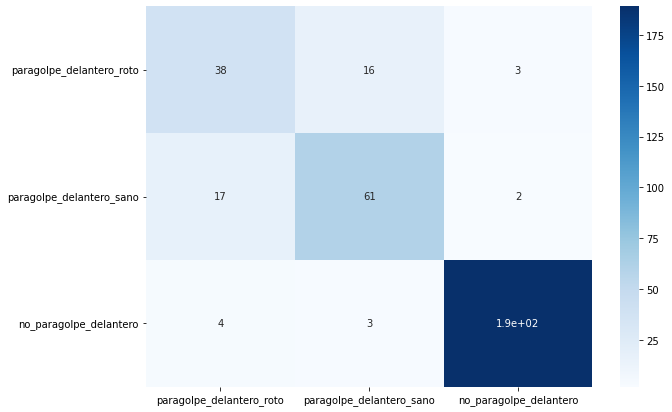

In [12]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(metrics_result['confusion_matrix'], index = classes,
                  columns = classes)

df_cm = df_cm.applymap(lambda x: x.item())

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")
df_cm.to_csv('./trained_models/{}/{}/confusion_matrix.csv'.format(MODEL_NAME, EXPERIMENT_NAME))